In [ ]:
import numpy as np
import pandas as pd
from scipy.special import expit as plogis
from scipy.stats import multivariate_normal
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


In [ ]:
def dgp_simulation(n_obs=20000, 
                   SEED=123,
                   beta_0=0.45,        # Intercept
                   beta_t=-0.85,       # Treatement Effect
                   beta_X=[-0.5, 0.1], # Effects of Covariates
                   beta_TX=[0.7],      # Interaction Effect
                   p0=0,               # Noise variables 
                   confounder=False
                   ):
    
    np.random.seed(SEED)

    p = len(beta_X) 
    mu = np.zeros(p + p0)
    rho = 0.1
    Sigma = np.full((p + p0, p + p0), rho)
    np.fill_diagonal(Sigma, 1)             # Covariance Matrix

    data = multivariate_normal.rvs(mean=mu, cov=Sigma, size=n_obs)
    data_df = pd.DataFrame(data, columns=[f'X{i+1}' for i in range(p + p0)])

    beta_X_full = np.array(beta_X + [0] * p0)          # array with covarites  + noise vars
    beta_TX = np.array(beta_TX)

    if confounder is not False:
        Tr = np.random.binomial(1, plogis(0.5 * data_df.iloc[:, confounder]), size=n_obs)
    else:
        Tr = np.random.binomial(1, 0.5, size=n_obs)

    Tr = np.array(Tr)
    X_effect = data @ beta_X_full
    interaction = (data[:, :len(beta_TX)] @ beta_TX) * Tr
    logit_Y = beta_0 + beta_t * Tr + X_effect + interaction

    Y_prob = plogis(logit_Y)
    Y = np.random.binomial(1, Y_prob)

    Y1 = plogis(beta_0 + beta_t + X_effect + data[:, 0] * beta_TX[0])
    Y0 = plogis(beta_0 + X_effect)
    ITE_true = Y1 - Y0

    simulated_df = pd.DataFrame({
        'ID': np.arange(1, n_obs + 1),
        'Y': Y,
        'Treatment': Tr,
        **data_df,
        'Y1': Y1,
        'Y0': Y0,
        'ITE_true': ITE_true,
        'Y_prob': Y_prob
    })

    return simulated_df

def split_train_val_test(df, val_size=0.25, test_size=0.25, seed=12345):
    # First split off test set
    df_train_val, df_test = train_test_split(df, test_size=test_size, random_state=seed)
    # Then split train/val
    relative_val_size = val_size / (1 - test_size)
    df_train, df_val = train_test_split(df_train_val, test_size=relative_val_size, random_state=seed)
    return df_train.reset_index(drop=True), df_val.reset_index(drop=True), df_test.reset_index(drop=True)

In [12]:
df = dgp_simulation(n_obs=10000)
df_train, df_val, df_test = split_train_val_test(df)

In [14]:
# True ATEs from known potential outcomes
ate_train = df_train['ITE_true'].mean()
ate_test = df_test['ITE_true'].mean()

print(f"True ATE (train): {ate_train:.4f}")
print(f"True ATE (test):  {ate_test:.4f}")

True ATE (train): -0.2024
True ATE (test):  -0.2106


In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

def t_learner_logistic(df_train, df_test, feature_cols, outcome_col='Y', treatment_col='Treatment'):
    # Split the training set into treated and untreated
    treated = df_train[df_train[treatment_col] == 1]
    untreated = df_train[df_train[treatment_col] == 0]

    # Train separate logistic regression models
    model_treated = LogisticRegression(max_iter=1000)
    model_treated.fit(treated[feature_cols], treated[outcome_col])

    model_untreated = LogisticRegression(max_iter=1000)
    model_untreated.fit(untreated[feature_cols], untreated[outcome_col])

    # Predict potential outcomes for all samples in test set
    mu1 = model_treated.predict_proba(df_test[feature_cols])[:, 1]
    mu0 = model_untreated.predict_proba(df_test[feature_cols])[:, 1]

    # ITE estimate = difference in predicted probabilities
    ite_estimate = mu1 - mu0

    # Optional: store in DataFrame
    df_result = df_test.copy()
    df_result['mu1_hat'] = mu1
    df_result['mu0_hat'] = mu0
    df_result['ITE_hat'] = ite_estimate

    return df_result, model_treated, model_untreated

In [ ]:
df = dgp_simulation(n_obs=10000)
df_train, df_val, df_test = split_train_val_test(df)

# Run the T-learner
df_result, model_t, model_u = t_learner_logistic(df_train, df_test, feature_cols =['X1', 'X2'])

# Optional: check estimated vs. true ITE
if 'ITE_true' in df_result.columns:
    print("Mean absolute error:", np.mean(np.abs(df_result['ITE_hat'] - df_result['ITE_true'])))


Mean absolute error: 0.015469935994933801


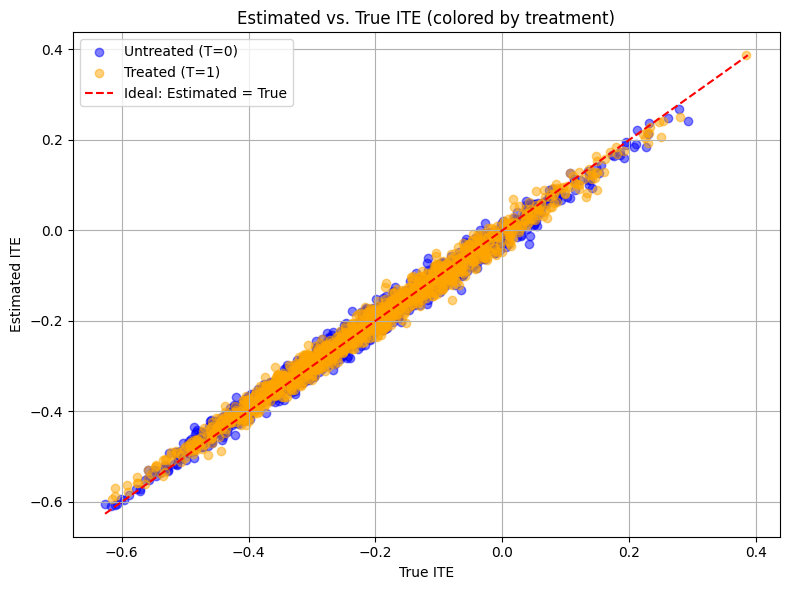

In [ ]:

def plot_estimated_vs_true_ite_colored(df_result):
    plt.figure(figsize=(8, 6))

    # Scatter: untreated
    untreated = df_result[df_result['Treatment'] == 0]
    plt.scatter(untreated['ITE_true'], untreated['ITE_hat'], alpha=0.5, label='Untreated (T=0)', color='blue')

    # Scatter: treated
    treated = df_result[df_result['Treatment'] == 1]
    plt.scatter(treated['ITE_true'], treated['ITE_hat'], alpha=0.5, label='Treated (T=1)', color='orange')

    # Diagonal reference line
    min_val = min(df_result['ITE_true'].min(), df_result['ITE_hat'].min())
    max_val = max(df_result['ITE_true'].max(), df_result['ITE_hat'].max())
    plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', label='Ideal: Estimated = True')

    plt.xlabel('True ITE')
    plt.ylabel('Estimated ITE')
    plt.title('Estimated vs. True ITE (colored by treatment)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
plot_estimated_vs_true_ite_colored(df_result)


In [35]:
df_result

,ID,Y,Treatment,X1,X2,Y1,Y0,ITE_true,Y_prob,mu1_hat,mu0_hat,ITE_hat
0,7868,0,0,0.419597,-0.663250,0.405547,0.543360,-0.137813,0.543360,0.371,0.203,0.168
1,1403,0,0,-2.523922,-0.619833,0.275525,0.838888,-0.563363,0.838888,0.179,0.823,-0.644
2,8607,1,0,0.510189,-0.103083,0.423537,0.546019,-0.122482,0.546019,0.687,0.531,0.156
3,8886,0,0,-0.237004,1.787173,0.433230,0.678572,-0.245342,0.678572,0.294,0.820,-0.526
4,6495,1,1,0.247624,1.955434,0.461344,0.627553,-0.166208,0.461344,0.277,0.066,0.211
...,...,...,...,...,...,...,...,...,...,...,...,...
2495,2150,1,1,0.313633,-1.533935,0.379736,0.534891,-0.155154,0.379736,0.418,0.490,-0.072
2496,6329,0,1,-0.803653,-2.271369,0.312627,0.651284,-0.338658,0.312627,0.148,0.498,-0.350
2497,3953,0,1,1.277247,-1.265109,0.432647,0.421862,0.010784,0.432647,0.331,0.361,-0.030
2498,7481,1,0,-0.739292,-1.733326,0.327131,0.656179,-0.329048,0.656179,0.467,0.754,-0.287


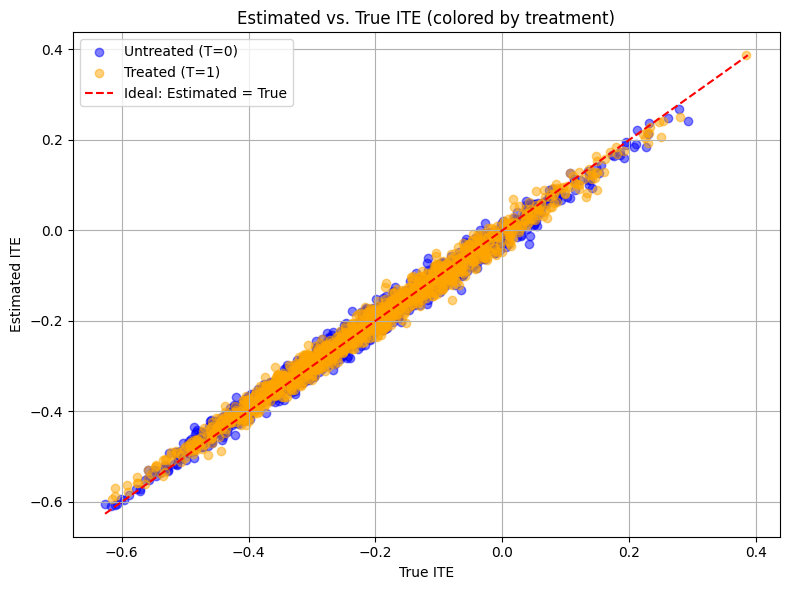

In [ ]:
# 1. Simulate and split
df = dgp_simulation(n_obs=10000)
df_train, df_val, df_test = split_train_val_test(df)

# 2. Run T-learner on train data and apply to test set
feature_cols = ['X1', 'X2']  # or however many features you want
df_result, model_t, model_u = t_learner_logistic(df_train, df_test, feature_cols)

plot_estimated_vs_true_ite_colored(df_result)

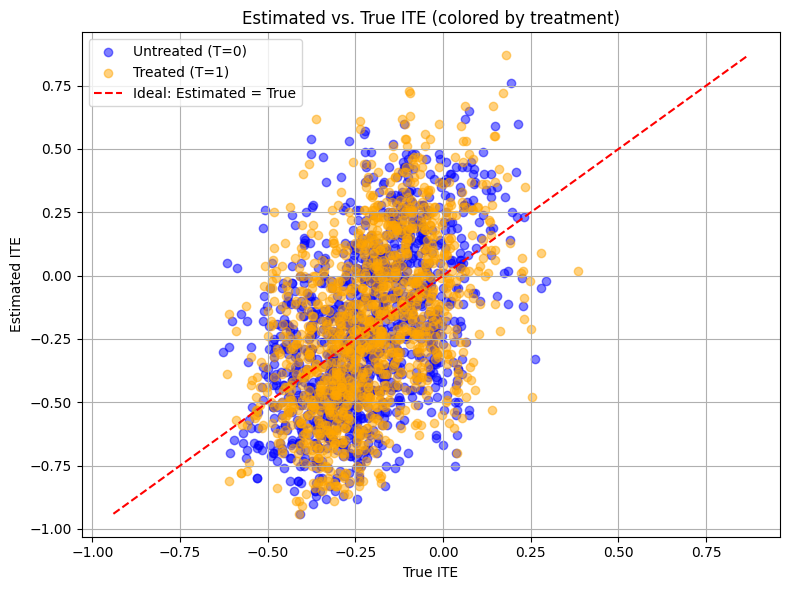

In [ ]:
from sklearn.ensemble import RandomForestClassifier

def t_learner_random_forest(df_train, df_test, feature_cols, outcome_col='Y', treatment_col='Treatment'):
    # Split training data into treated and untreated
    treated = df_train[df_train[treatment_col] == 1]
    untreated = df_train[df_train[treatment_col] == 0]

    # Train separate random forest classifiers
    model_treated = RandomForestClassifier(n_estimators=1000, random_state=0)
    model_treated.fit(treated[feature_cols], treated[outcome_col])

    model_untreated = RandomForestClassifier(n_estimators=1000, random_state=0)
    model_untreated.fit(untreated[feature_cols], untreated[outcome_col])

    # Predict potential outcomes on test set
    mu1 = model_treated.predict_proba(df_test[feature_cols])[:, 1]
    mu0 = model_untreated.predict_proba(df_test[feature_cols])[:, 1]

    # ITE estimate
    ite_estimate = mu1 - mu0

    # Store results
    df_result = df_test.copy()
    df_result['mu1_hat'] = mu1
    df_result['mu0_hat'] = mu0
    df_result['ITE_hat'] = ite_estimate

    return df_result, model_treated, model_untreated
 


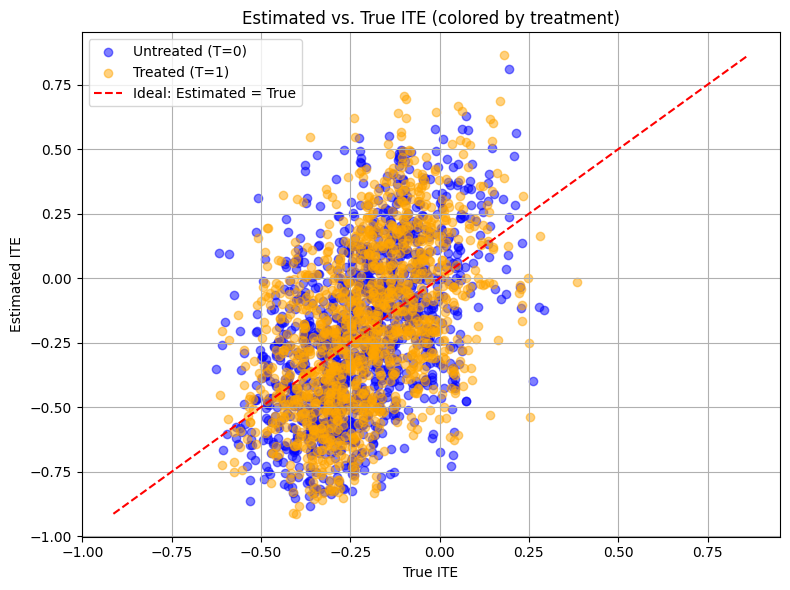

In [34]:
# 1. Simulate and split
df = dgp_simulation(n_obs=10000)
df_train, df_val, df_test = split_train_val_test(df)

# 2. T-learner with random forests
feature_cols = ['X1', 'X2']
df_result, model_t, model_u = t_learner_random_forest(df_train, df_test, feature_cols)

# 3. Visualize
plot_estimated_vs_true_ite_colored(df_result)
